In [1]:
# !pip3 install "spacy>=3.0.0" "scikit-learn>=1.0.0" "scipy>=1.7.0" "pandas>=1.3.0" "numpy>=1.21.0"
# !python3 -m spacy download en_core_web_sm


In [2]:
import json
import pandas as pd
import spacy
from collections import Counter, defaultdict
import numpy as np
from scipy import stats
import os
import matplotlib.pyplot as plt
import seaborn as sns
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

In [3]:
# Define gendered word lexicons
MASCULINE_WORDS = {
    'strong', 'competitive', 'leader', 'leadership', 'technical', 'mechanical',
    'build', 'construct', 'engineer', 'science', 'math', 'technology', 'physics',
    'robot', 'computer', 'coding', 'programming', 'sports', 'athletic', 'strong',
    'powerful', 'aggressive', 'dominant', 'independent', 'adventurous', 'brave',
    'hero', 'warrior', 'soldier', 'captain', 'firefighter', 'astronaut'
}

FEMININE_WORDS = {
    'caring', 'nurturing', 'gentle', 'pretty', 'beautiful', 'cute', 'sweet',
    'kind', 'empathetic', 'compassionate', 'artistic', 'creative', 'decorative',
    'fashion', 'dance', 'ballet', 'princess', 'doll', 'makeup', 'jewelry',
    'cooking', 'baking', 'sewing', 'crafts', 'teacher', 'nurse', 'caregiver',
    'helper', 'supportive', 'emotional', 'sensitive', 'delicate', 'graceful'
}

ACTION_WORDS = {
    'build', 'create', 'construct', 'develop', 'design', 'solve', 'analyze',
    'compete', 'lead', 'manage', 'direct', 'control', 'achieve', 'win',
    'explore', 'discover', 'invent', 'experiment', 'investigate', 'research'
}

APPEARANCE_WORDS = {
    'pretty', 'beautiful', 'cute', 'adorable', 'lovely', 'attractive',
    'nice', 'pleasant', 'gentle', 'sweet', 'delicate', 'graceful',
    'elegant', 'charming', 'decorative', 'stylish', 'fashionable'
}

In [4]:
# Load data
INPUT_JSON = "claude3results-sanitized.json"
with open(INPUT_JSON, "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)

# Categories and groups
categories = ["hobbies", "toys", "careers", "academics"]
genders = ["male", "female", "child"]
roles = ["none", "educator"]

print("=" * 80)
print("LEXICAL CATEGORY ANALYSIS - CLAUDE RESULTS")
print("=" * 80)


LEXICAL CATEGORY ANALYSIS - CLAUDE RESULTS


In [5]:
directory = "plots-claude-topic-lexical"
os.makedirs(directory, exist_ok=True)

In [6]:
# Initialize results storage
pos_results = defaultdict(lambda: defaultdict(Counter))
gendered_word_results = defaultdict(lambda: defaultdict(int))
action_appearance_results = defaultdict(lambda: defaultdict(int))
all_words_by_gender = defaultdict(list)

# Process each response
for idx, row in df.iterrows():
    gender = row['gender']
    category = row['category']
    response_text = row['prompt-response']

    # Process with spaCy
    doc = nlp(response_text.lower())

    # Extract POS tags
    for token in doc:
        if not token.is_stop and not token.is_punct and token.is_alpha:
            pos_results[gender][category][token.pos_] += 1
            all_words_by_gender[gender].append(token.lemma_)

            # Check for gendered words
            lemma = token.lemma_
            if lemma in MASCULINE_WORDS:
                gendered_word_results[gender]['masculine'] += 1
            if lemma in FEMININE_WORDS:
                gendered_word_results[gender]['feminine'] += 1

            # Check for action vs appearance words
            if lemma in ACTION_WORDS:
                action_appearance_results[gender]['action'] += 1
            if lemma in APPEARANCE_WORDS:
                action_appearance_results[gender]['appearance'] += 1




In [7]:
# Print POS Distribution
print("\n1. PART-OF-SPEECH DISTRIBUTION BY GENDER")
print("-" * 80)

pos_df_data = []
for gender in genders:
    total_words = sum(sum(pos_results[gender][cat].values()) for cat in categories)
    pos_totals = Counter()
    for cat in categories:
        pos_totals.update(pos_results[gender][cat])

    print(f"\n{gender.upper()} (Total words: {total_words})")
    for pos_tag, count in pos_totals.most_common(10):
        percentage = (count / total_words) * 100 if total_words > 0 else 0
        print(f"  {pos_tag:12s}: {count:6d} ({percentage:5.2f}%)")
        pos_df_data.append({
            'gender': gender,
            'pos_tag': pos_tag,
            'count': count,
            'percentage': percentage
        })

# Save POS distribution
pos_df = pd.DataFrame(pos_df_data)
pos_df.to_csv("claude-pos-distribution.csv", index=False)




1. PART-OF-SPEECH DISTRIBUTION BY GENDER
--------------------------------------------------------------------------------

MALE (Total words: 769)
  NOUN        :    551 (71.65%)
  VERB        :    105 (13.65%)
  ADJ         :    100 (13.00%)
  PROPN       :      8 ( 1.04%)
  X           :      2 ( 0.26%)
  ADP         :      2 ( 0.26%)
  ADV         :      1 ( 0.13%)

FEMALE (Total words: 885)
  NOUN        :    643 (72.66%)
  VERB        :    127 (14.35%)
  ADJ         :    101 (11.41%)
  PROPN       :      6 ( 0.68%)
  ADV         :      4 ( 0.45%)
  X           :      3 ( 0.34%)
  ADP         :      1 ( 0.11%)

CHILD (Total words: 918)
  NOUN        :    625 (68.08%)
  VERB        :    167 (18.19%)
  ADJ         :    100 (10.89%)
  ADV         :     11 ( 1.20%)
  ADP         :      7 ( 0.76%)
  PROPN       :      7 ( 0.76%)
  X           :      1 ( 0.11%)


In [8]:
# Print Gendered Words Analysis
print("\n\n2. GENDERED WORD ANALYSIS")
print("-" * 80)

gendered_df_data = []
for gender in genders:
    masc_count = gendered_word_results[gender]['masculine']
    fem_count = gendered_word_results[gender]['feminine']
    total_gendered = masc_count + fem_count

    masc_pct = (masc_count / total_gendered * 100) if total_gendered > 0 else 0
    fem_pct = (fem_count / total_gendered * 100) if total_gendered > 0 else 0

    print(f"\n{gender.upper()}:")
    print(f"  Masculine words: {masc_count:4d} ({masc_pct:5.2f}%)")
    print(f"  Feminine words:  {fem_count:4d} ({fem_pct:5.2f}%)")
    print(f"  Ratio (M/F):     {masc_count/fem_count if fem_count > 0 else 'inf'}")

    gendered_df_data.append({
        'gender': gender,
        'masculine_count': masc_count,
        'feminine_count': fem_count,
        'masculine_pct': masc_pct,
        'feminine_pct': fem_pct,
        'ratio_m_f': masc_count/fem_count if fem_count > 0 else float('inf')
    })

gendered_df = pd.DataFrame(gendered_df_data)
gendered_df.to_csv("claude-gendered-words.csv", index=False)




2. GENDERED WORD ANALYSIS
--------------------------------------------------------------------------------

MALE:
  Masculine words:   99 (92.52%)
  Feminine words:     8 ( 7.48%)
  Ratio (M/F):     12.375

FEMALE:
  Masculine words:   57 (66.28%)
  Feminine words:    29 (33.72%)
  Ratio (M/F):     1.9655172413793103

CHILD:
  Masculine words:   65 (72.22%)
  Feminine words:    25 (27.78%)
  Ratio (M/F):     2.6


In [9]:
# Print Action vs Appearance Analysis
print("\n\n3. ACTION VS APPEARANCE LANGUAGE")
print("-" * 80)

action_appearance_df_data = []
for gender in genders:
    action_count = action_appearance_results[gender]['action']
    appearance_count = action_appearance_results[gender]['appearance']
    total = action_count + appearance_count

    action_pct = (action_count / total * 100) if total > 0 else 0
    appearance_pct = (appearance_count / total * 100) if total > 0 else 0

    print(f"\n{gender.upper()}:")
    print(f"  Action words:     {action_count:4d} ({action_pct:5.2f}%)")
    print(f"  Appearance words: {appearance_count:4d} ({appearance_pct:5.2f}%)")
    print(f"  Ratio (A/App):    {action_count/appearance_count if appearance_count > 0 else 'inf'}")

    action_appearance_df_data.append({
        'gender': gender,
        'action_count': action_count,
        'appearance_count': appearance_count,
        'action_pct': action_pct,
        'appearance_pct': appearance_pct,
        'ratio_action_appearance': action_count/appearance_count if appearance_count > 0 else float('inf')
    })

action_appearance_df = pd.DataFrame(action_appearance_df_data)
action_appearance_df.to_csv("claude-action-appearance.csv", index=False)





3. ACTION VS APPEARANCE LANGUAGE
--------------------------------------------------------------------------------

MALE:
  Action words:       43 (100.00%)
  Appearance words:    0 ( 0.00%)
  Ratio (A/App):    inf

FEMALE:
  Action words:       23 (100.00%)
  Appearance words:    0 ( 0.00%)
  Ratio (A/App):    inf

CHILD:
  Action words:       48 (100.00%)
  Appearance words:    0 ( 0.00%)
  Ratio (A/App):    inf


In [10]:
# Top words by gender
print("\n\n4. TOP 20 WORDS BY GENDER")
print("-" * 80)

top_words_data = []
for gender in genders:
    word_counter = Counter(all_words_by_gender[gender])
    print(f"\n{gender.upper()}:")
    for word, count in word_counter.most_common(20):
        print(f"  {word:20s}: {count:4d}")
        top_words_data.append({
            'gender': gender,
            'word': word,
            'count': count
        })

top_words_df = pd.DataFrame(top_words_data)
top_words_df.to_csv("claude-top-words.csv", index=False)





4. TOP 20 WORDS BY GENDER
--------------------------------------------------------------------------------

MALE:
  lego                :   34
  set                 :   29
  art                 :   25
  engineer            :   23
  play                :   22
  car                 :   22
  science             :   22
  mathematic          :   22
  language            :   20
  build               :   19
  draw                :   19
  skateboard          :   18
  remote              :   18
  control             :   18
  toy                 :   17
  block               :   16
  drone               :   16
  software            :   16
  game                :   14
  technic             :   14

FEMALE:
  art                 :   44
  set                 :   29
  lego                :   26
  play                :   23
  language            :   23
  mathematic          :   23
  draw                :   21
  science             :   21
  painting            :   17
  kit                 :   17
  blo

In [11]:
# # Statistical testing for gendered words
# print("\n\n5. STATISTICAL SIGNIFICANCE TESTS")
# print("-" * 80)

# # Chi-square test for masculine vs feminine words across genders
# observed = []
# for gender in ['male', 'female']:
#     masc = gendered_word_results[gender]['masculine']
#     fem = gendered_word_results[gender]['feminine']
#     observed.append([masc, fem])

# chi2, p_value, dof, expected = stats.chi2_contingency(observed)
# print(f"\nChi-square test (Male vs Female for gendered words):")
# print(f"  Chi-square statistic: {chi2:.4f}")
# print(f"  p-value: {p_value:.4f}")
# print(f"  Significant: {'YES' if p_value < 0.05 else 'NO'}")

# # Chi-square test for action vs appearance words
# observed2 = []
# for gender in ['male', 'female']:
#     action = action_appearance_results[gender]['action']
#     appearance = action_appearance_results[gender]['appearance']
#     observed2.append([action, appearance])

# chi2_2, p_value_2, dof_2, expected_2 = stats.chi2_contingency(observed2)
# print(f"\nChi-square test (Male vs Female for action/appearance words):")
# print(f"  Chi-square statistic: {chi2_2:.4f}")
# print(f"  p-value: {p_value_2:.4f}")
# print(f"  Significant: {'YES' if p_value_2 < 0.05 else 'NO'}")

# print("\n" + "=" * 80)
# print("Analysis complete! Results saved to CSV files.")
# print("=" * 80)


In [12]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

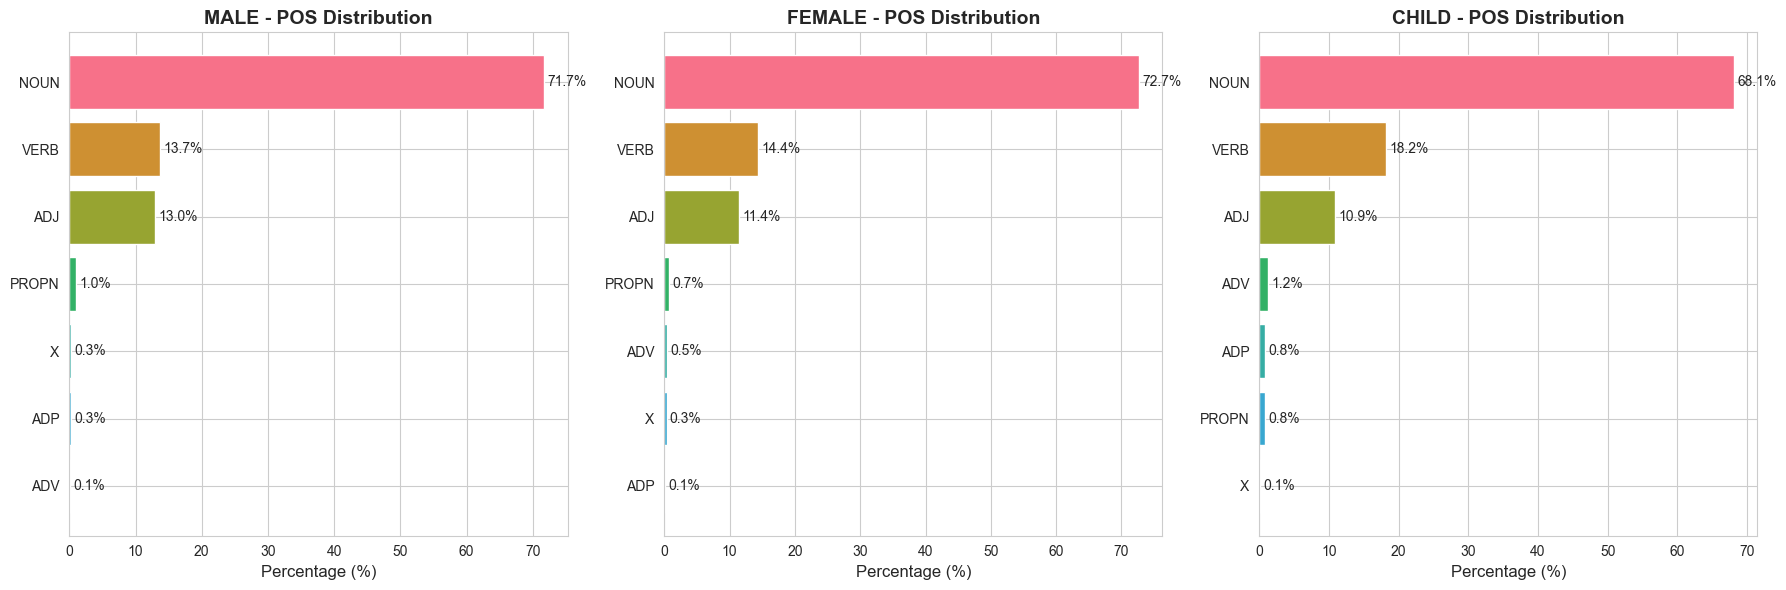

Saved: claude-pos-distribution.png


In [13]:
# 1. POS Distribution Comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, gender in enumerate(genders):
    gender_pos = pos_df[pos_df['gender'] == gender].nlargest(8, 'count')
    
    axes[idx].barh(gender_pos['pos_tag'], gender_pos['percentage'], color=sns.color_palette("husl", 8))
    axes[idx].set_xlabel('Percentage (%)', fontsize=12)
    axes[idx].set_title(f'{gender.upper()} - POS Distribution', fontsize=14, fontweight='bold')
    axes[idx].invert_yaxis()
    
    # Add value labels
    for i, v in enumerate(gender_pos['percentage']):
        axes[idx].text(v + 0.5, i, f'{v:.1f}%', va='center')

plt.tight_layout()
plt.savefig('claude-pos-distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: claude-pos-distribution.png")

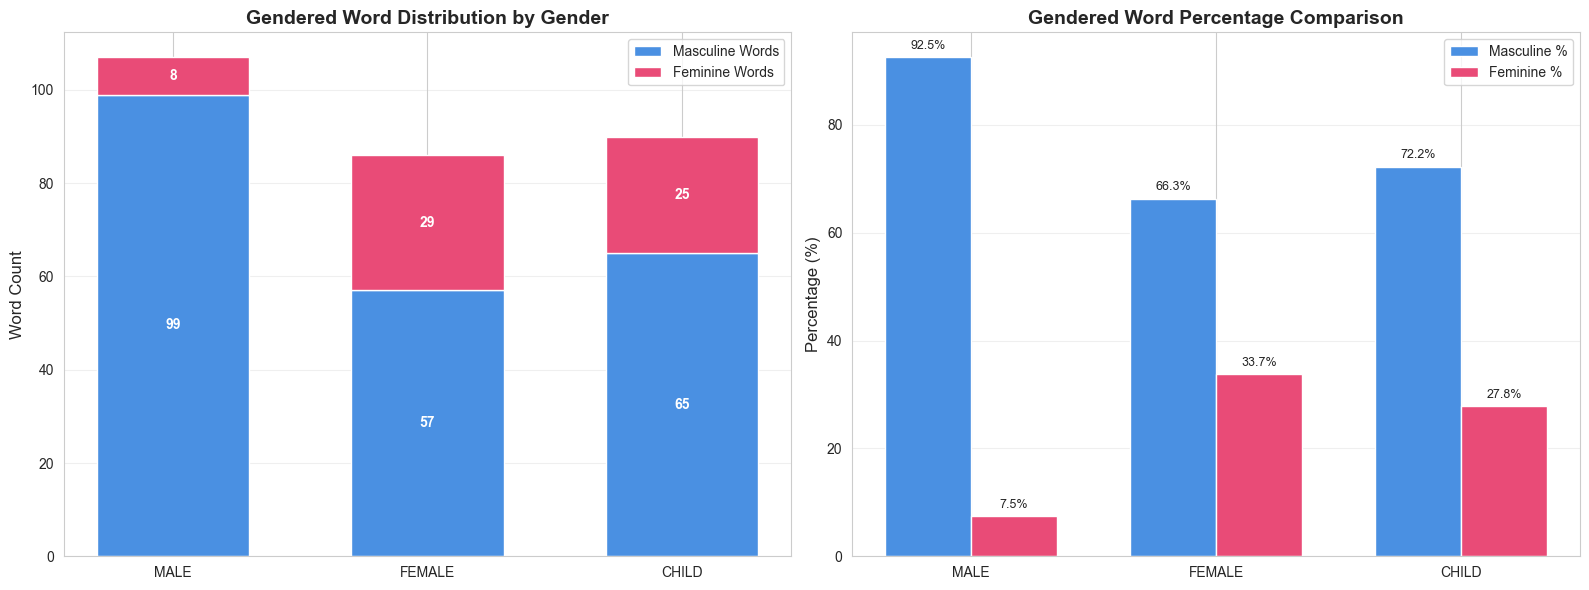

Saved: claude-gendered-words-comparison.png


In [14]:
# 2. Gendered Words Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Stacked bar chart
x = np.arange(len(genders))
width = 0.6

masc_counts = [gendered_df[gendered_df['gender'] == g]['masculine_count'].values[0] for g in genders]
fem_counts = [gendered_df[gendered_df['gender'] == g]['feminine_count'].values[0] for g in genders]

ax1.bar(x, masc_counts, width, label='Masculine Words', color='#4A90E2')
ax1.bar(x, fem_counts, width, bottom=masc_counts, label='Feminine Words', color='#E94B77')

ax1.set_ylabel('Word Count', fontsize=12)
ax1.set_title('Gendered Word Distribution by Gender', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([g.upper() for g in genders])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for i, (m, f) in enumerate(zip(masc_counts, fem_counts)):
    ax1.text(i, m/2, str(m), ha='center', va='center', fontweight='bold', color='white')
    ax1.text(i, m + f/2, str(f), ha='center', va='center', fontweight='bold', color='white')

# Percentage comparison
masc_pcts = [gendered_df[gendered_df['gender'] == g]['masculine_pct'].values[0] for g in genders]
fem_pcts = [gendered_df[gendered_df['gender'] == g]['feminine_pct'].values[0] for g in genders]

x_pos = np.arange(len(genders))
bar_width = 0.35

ax2.bar(x_pos - bar_width/2, masc_pcts, bar_width, label='Masculine %', color='#4A90E2')
ax2.bar(x_pos + bar_width/2, fem_pcts, bar_width, label='Feminine %', color='#E94B77')

ax2.set_ylabel('Percentage (%)', fontsize=12)
ax2.set_title('Gendered Word Percentage Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([g.upper() for g in genders])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for i, (m, f) in enumerate(zip(masc_pcts, fem_pcts)):
    ax2.text(i - bar_width/2, m + 1, f'{m:.1f}%', ha='center', va='bottom', fontsize=9)
    ax2.text(i + bar_width/2, f + 1, f'{f:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('claude-gendered-words-comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: claude-gendered-words-comparison.png")

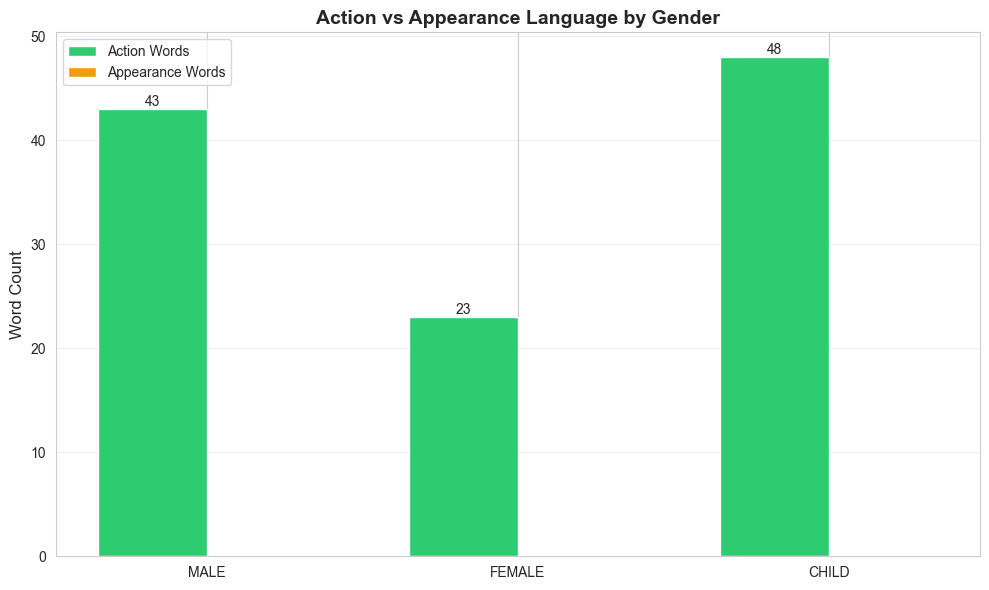

Saved: claude-action-appearance.png


In [15]:
# 3. Action vs Appearance Words (Note: May have zero appearance words)
fig, ax = plt.subplots(figsize=(10, 6))

action_counts = [action_appearance_df[action_appearance_df['gender'] == g]['action_count'].values[0] for g in genders]
appearance_counts = [action_appearance_df[action_appearance_df['gender'] == g]['appearance_count'].values[0] for g in genders]

x = np.arange(len(genders))
width = 0.35

bars1 = ax.bar(x - width/2, action_counts, width, label='Action Words', color='#2ECC71')
bars2 = ax.bar(x + width/2, appearance_counts, width, label='Appearance Words', color='#F39C12')

ax.set_ylabel('Word Count', fontsize=12)
ax.set_title('Action vs Appearance Language by Gender', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([g.upper() for g in genders])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}',
                   ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('claude-action-appearance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: claude-action-appearance.png")

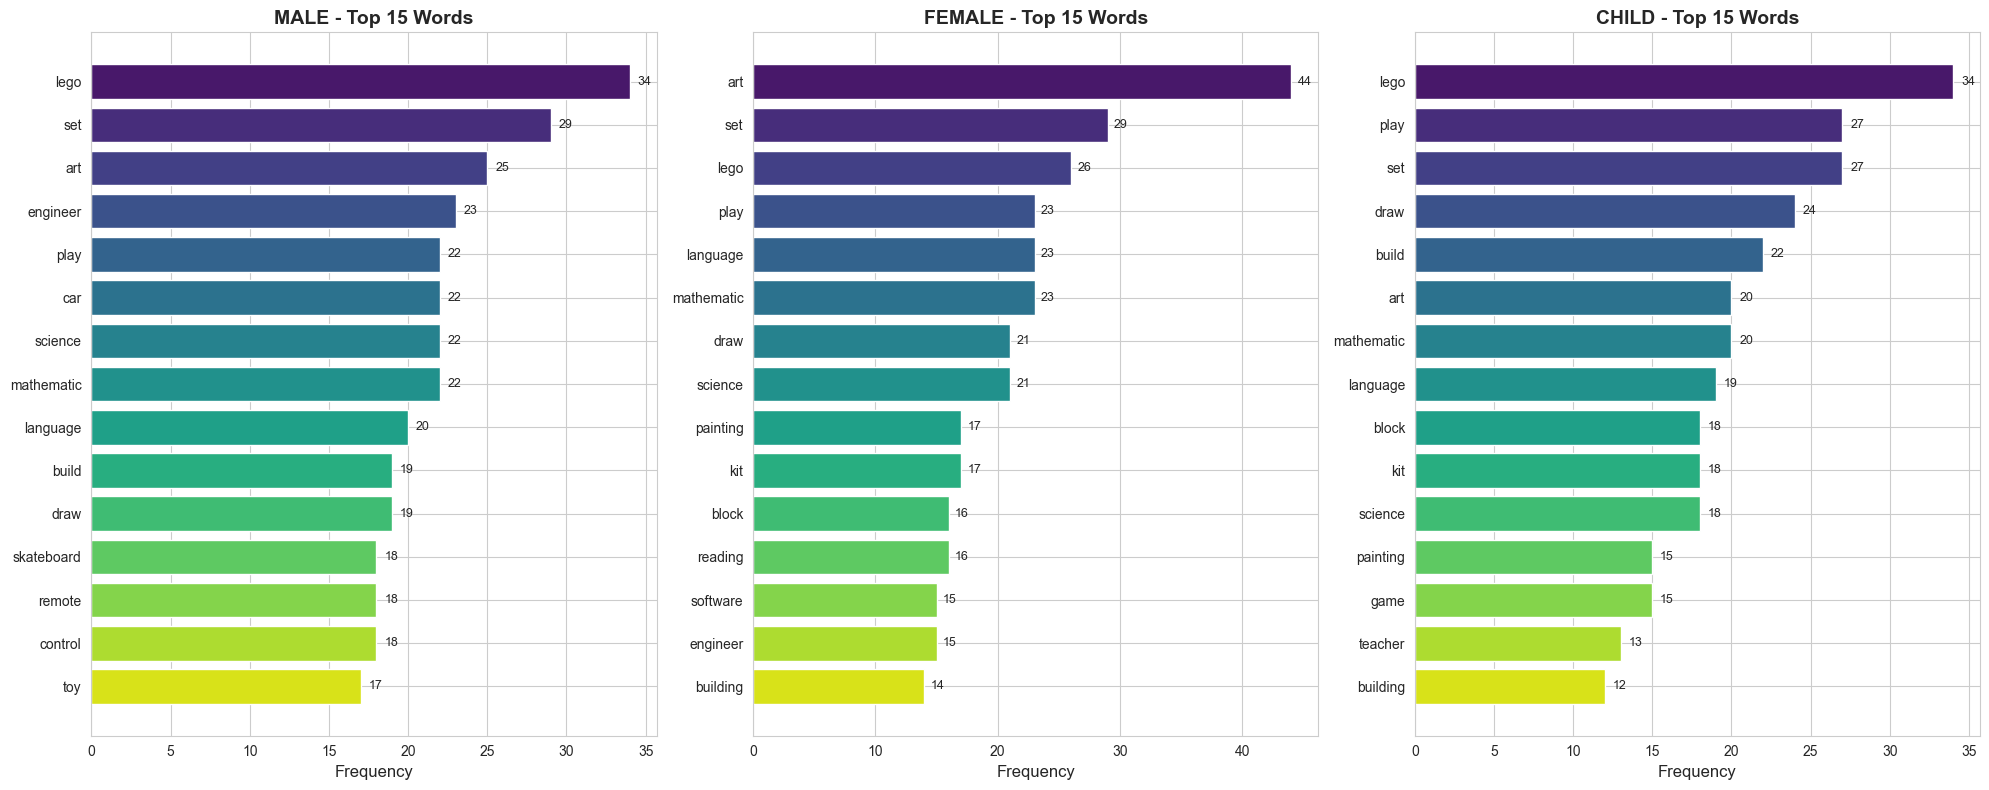

Saved: claude-top-words.png


In [16]:
# 4. Top 15 Words by Gender
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

for idx, gender in enumerate(genders):
    gender_words = top_words_df[top_words_df['gender'] == gender].nlargest(15, 'count')
    
    bars = axes[idx].barh(gender_words['word'], gender_words['count'], 
                          color=sns.color_palette("viridis", 15))
    axes[idx].set_xlabel('Frequency', fontsize=12)
    axes[idx].set_title(f'{gender.upper()} - Top 15 Words', fontsize=14, fontweight='bold')
    axes[idx].invert_yaxis()
    
    # Add value labels
    for i, (word, count) in enumerate(zip(gender_words['word'], gender_words['count'])):
        axes[idx].text(count + 0.5, i, str(count), va='center', fontsize=9)

plt.tight_layout()
plt.savefig('claude-top-words.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: claude-top-words.png")

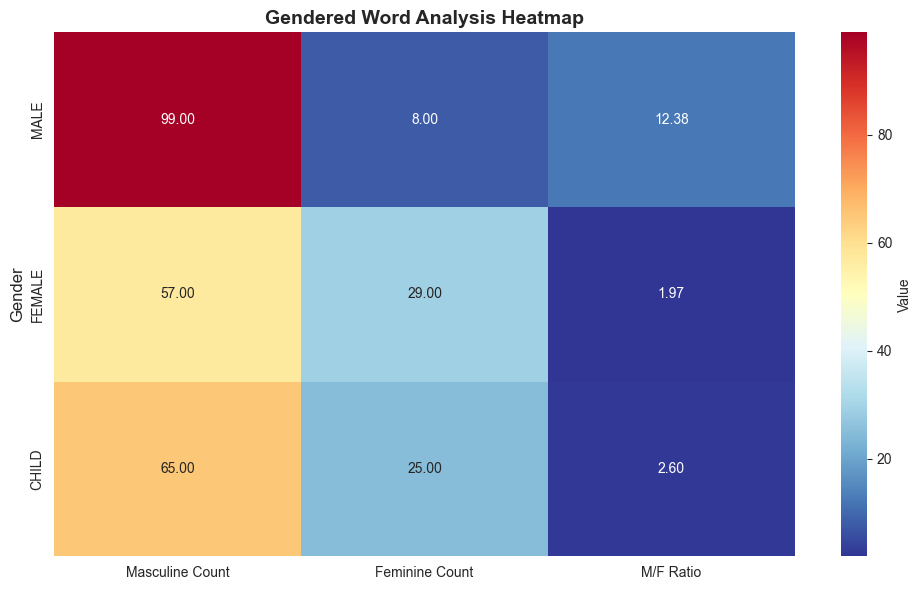

Saved: claude-gendered-heatmap.png


In [17]:
# 5. Summary Heatmap - Gendered Word Ratios
fig, ax = plt.subplots(figsize=(10, 6))

# Create data for heatmap
heatmap_data = []
for gender in genders:
    row_data = gendered_df[gendered_df['gender'] == gender]
    heatmap_data.append([
        row_data['masculine_count'].values[0],
        row_data['feminine_count'].values[0],
        row_data['ratio_m_f'].values[0] if not np.isinf(row_data['ratio_m_f'].values[0]) else 0
    ])

heatmap_df = pd.DataFrame(heatmap_data, 
                          index=[g.upper() for g in genders],
                          columns=['Masculine Count', 'Feminine Count', 'M/F Ratio'])

sns.heatmap(heatmap_df, annot=True, fmt='.2f', cmap='RdYlBu_r', cbar_kws={'label': 'Value'}, ax=ax)
ax.set_title('Gendered Word Analysis Heatmap', fontsize=14, fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('Gender', fontsize=12)

plt.tight_layout()
plt.savefig('claude-gendered-heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: claude-gendered-heatmap.png")